In [20]:
# Import Libraries
# for text preprocessing
import re
# import spacy
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
# import numpy for matrix operation
import numpy as np
# Importing Gensim
import gensim
from gensim import corpora  
import pandas as pd

In [21]:
import ast
dataframe = pd.read_csv("./data/preprocessed.csv")
clean_corpus = [ast.literal_eval(x) for x in dataframe["preprocessed"]]

In [22]:
# where every unique term is assigned an index.
dict_ = corpora.Dictionary(clean_corpus)

In [23]:
# Converting list of documents (corpus) into Document Term Matrix using the dictionary
doc_term_matrix = [dict_.doc2bow(i) for i in clean_corpus]

In [24]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix.
ldamodel = Lda(corpus=doc_term_matrix, num_topics=6, id2word = dict_, passes=20, random_state=20, eval_every=None)

# Prints the topics with the indexes: 0,1,2 :
ldamodel.print_topics()
# we need to manually check whethere the topics are different from one another or not
# print(ldamodel.print_topics(num_topics=6, num_words=5))

# num_topics mean: how many topics want to extract
# num_words: the number of words that want per topic


[(0,
  '0.010*"price" + 0.008*"country" + 0.007*"rate" + 0.007*"like" + 0.006*"people" + 0.005*"even" + 0.005*"good" + 0.005*"world" + 0.005*"year" + 0.005*"dont"'),
 (1,
  '0.009*"golden" + 0.009*"peso" + 0.007*"haha" + 0.006*"daw" + 0.005*"bigas" + 0.005*"leni" + 0.005*"anak" + 0.004*"build" + 0.004*"era" + 0.004*"hahaha"'),
 (2,
  '0.007*"dont" + 0.007*"economy" + 0.006*"one" + 0.006*"people" + 0.005*"like" + 0.005*"get" + 0.005*"think" + 0.005*"want" + 0.005*"know" + 0.005*"time"'),
 (3,
  '0.012*"wala" + 0.010*"bilihin" + 0.008*"sana" + 0.007*"gobyerno" + 0.006*"tapos" + 0.006*"alam" + 0.006*"unity" + 0.006*"bansa" + 0.005*"nang" + 0.005*"n"'),
 (4,
  '0.011*"share" + 0.008*"mb" + 0.007*"company" + 0.007*"ipo" + 0.006*"billion" + 0.006*"stock" + 0.006*"market" + 0.006*"price" + 0.005*"take" + 0.005*"pse"'),
 (5,
  '0.011*"k" + 0.006*"covid" + 0.005*"kuryente" + 0.005*"mahal" + 0.005*"pbbm" + 0.005*"bansa" + 0.004*"bbm" + 0.004*"pilipinas" + 0.004*"baka" + 0.003*"bill"')]

In [25]:
# Train model with increasing number of topics

limit=12; start=2; step=1


def train_model_with_diff_topicN(dictionary, corpus, texts, limit, start=2, step=3):
   model_list = []
   for num_topics in range(start, limit, step):
      model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics=num_topics, id2word = dict_, passes=20, random_state=0, eval_every=None)
      model_list.append(model)
   return model_list

all_model_list = train_model_with_diff_topicN(dictionary=dict_, corpus=doc_term_matrix, texts=clean_corpus, limit=limit,start=start, step=step )

In [27]:
# A method for computing different coherence values(c_uci, c_npmi, u_mass) of all models with different number of topics. 

from gensim.models import CoherenceModel

def compute_coherence_values(model, dictionary,  texts):
   all_coherence_values ={}
   coherence_types = ["c_uci", "c_npmi", "u_mass"]
   coherence_values = []
   for coherence_type in coherence_types:
      coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence_type)
      coherence_values.append(coherence_model.get_coherence())
      
   return coherence_values

In [28]:
# Computes for the perplexity values of models with different number of topics

def compute_perplexity_values(model_list, doc_term_matrix):
   perplexity_values = []
   for model in model_list:
      perplexity_values.append(np.exp(-1 * model.log_perplexity(doc_term_matrix )))
     
   return perplexity_values

In [29]:
# A method for computing the pairwise Jaccard Similarity of topN topics from a model. 
from itertools import combinations


def pairwise_jaccard_diversity(topics, topk):
    '''
    compute the average pairwise jaccard distance between the topics
 
    Parameters
    ----------
    topics: a list of lists of words
    topk: top k words on which the topic diversity
          will be computed
   
    Returns
    -------
    pjd: average pairwise jaccard distance
    '''
    dist = 0
    count = 0
    for list1, list2 in combinations(topics, 2):
        # print(f"List 1: {list1} \n List 2: {list2}")
        js = 1 - len(set(list1).intersection(set(list2)))/len(set(list1).union(set(list2)))
        dist = dist + js
        count = count + 1
    return dist/count


In [30]:
# Computes for the jaccard similarity values of models with different number of topics

def compute_jaccard_similarity_values(model_list):
   n_topics =2 
   jaccard_scores = []
   for index,model in enumerate(model_list):
      # print(f'model No.: {index+1} | N Topics: {n_topics}')
      n_topics+=4
      all_topics = []
      for i in range(len(model.show_topics(num_topics=n_topics))):
         topic = [x[0] for x in model.show_topic(i, topn=6)]
         # print(f"topic: {topic}")
         all_topics.append(topic)
      jaccard_scores.append(pairwise_jaccard_diversity(all_topics, 6))
   
   return jaccard_scores

In [31]:
import concurrent.futures as cf
import itertools

workers = 8
 
all_coherence_values = []
with cf.ThreadPoolExecutor(max_workers=workers) as executor:
    #for n in executor.map(_findmatch, numberlist):
    for n in executor.map(compute_coherence_values, all_model_list, itertools.repeat(dict_), itertools.repeat(clean_corpus)):
        all_coherence_values.append(n)

In [32]:
all_coherence_values_temp = {"c_uci":[], "c_npmi":[], "u_mass":[]}
coherence_types = ["c_uci", "c_npmi", "u_mass"]
for coherence_values in all_coherence_values:
   for index,coherence_type in enumerate(coherence_types):
      all_coherence_values_temp[coherence_type].append(coherence_values[index])

In [33]:
# Runs the methods that retrieve the metrics for each models of varying topic count
all_perplexity_values= compute_perplexity_values(all_model_list, doc_term_matrix=doc_term_matrix)
all_jaccard_values = compute_jaccard_similarity_values(all_model_list)
all_coherence_values = all_coherence_values_temp

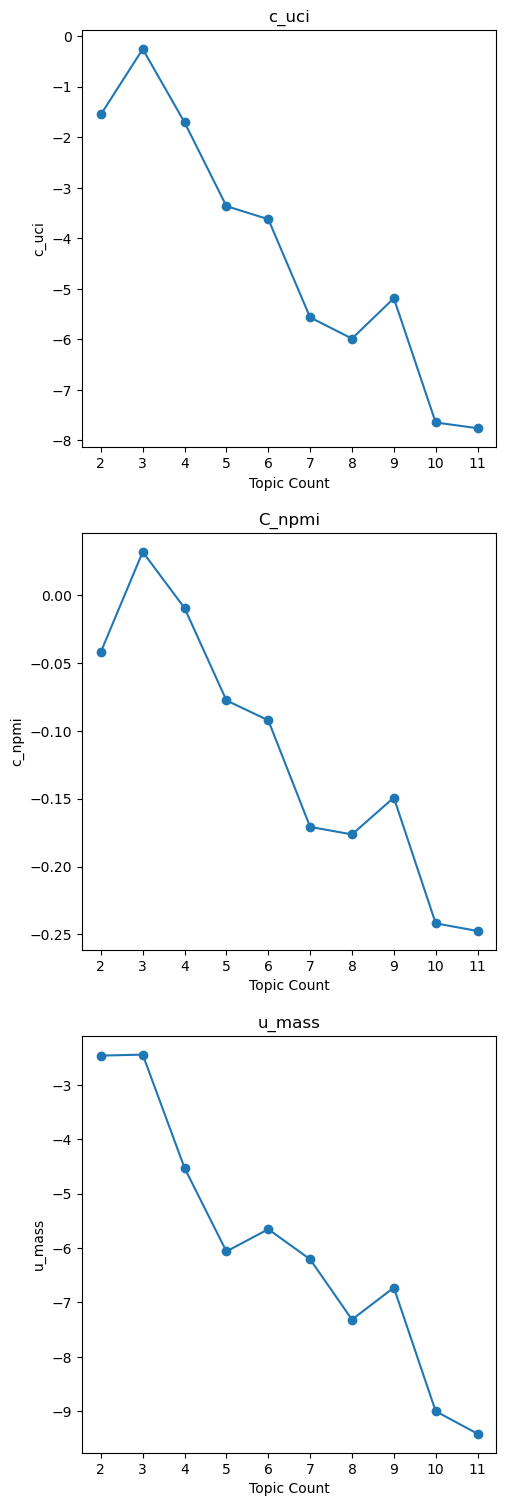

In [34]:
# Plots the coherence scores for each coherence value types. The x axis is the number of topics
# while the y axis is for the coherence score where the higher the value is the better. 


import matplotlib.pyplot as plt


x =[i for i in range(start, limit, step)]

coherence_types = ["c_uci", "c_npmi", "u_mass"]

fig, axs = plt.subplots(3,1)
fig.set_size_inches(5.5, 15.5)
axs[0,].plot(np.array(x), np.array(all_coherence_values["c_uci"]), marker='o', label="c_uci")
axs[0, ].set_title("c_uci")

axs[1,].plot(x, all_coherence_values["c_npmi"], marker='o', label="c_npmi")
axs[1, ].set_title("C_npmi")
axs[2,].plot(x, all_coherence_values["u_mass"], marker='o', label="u_mass")
axs[2, ].set_title("u_mass")
# fig.delaxes(axs[1][1])
fig.tight_layout(pad=3.0)

for i,ax in enumerate(axs.flat):
   if i ==3:
      break
   ax.set(xlabel='Topic Count', ylabel=coherence_types[i])
   ax.set_xticks(x)
   ax.set_xticklabels(x)
   

# for coherence_type in coherence_types:
#    ax.plot(x, all_coherence_values[coherence_type], marker='o', label=coherence_type)


Text(0.5, 1.0, 'Perplexity Scores')

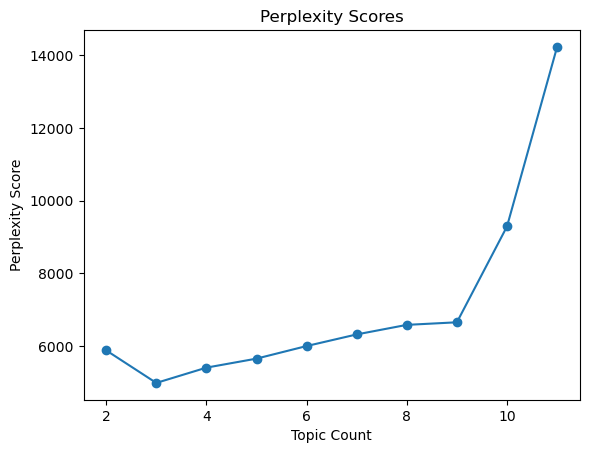

In [35]:
plt.plot(x,  all_perplexity_values, marker='o')
plt.xlabel('Topic Count')
plt.ylabel('Perplexity Score')
plt.title('Perplexity Scores')


Text(0.5, 1.0, 'Average Pairwise Jaccard Similarity')

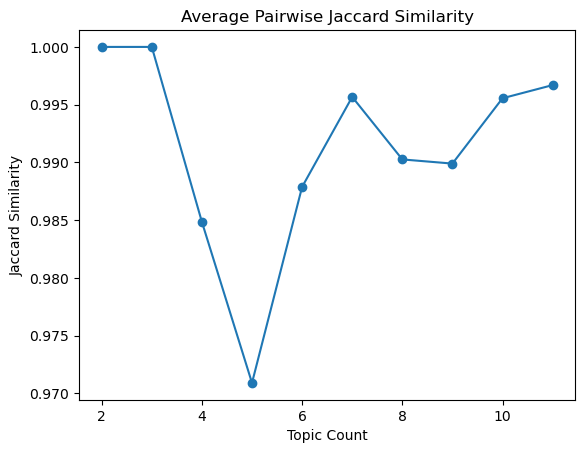

In [36]:
plt.plot(x,  all_jaccard_values , marker='o')
plt.xlabel('Topic Count')
plt.ylabel('Jaccard Similarity')
plt.title('Average Pairwise Jaccard Similarity')


In [40]:
import pyLDAvis

import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
%matplotlib inline

gensimvis.prepare(ldamodel ,doc_term_matrix , dict_)


c:\Users\Arian\.conda\envs\data-mining\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
c:\Users\Arian\.conda\envs\data-mining\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.161540  0.238153       1        1  33.077391
0      0.191857 -0.104422       2        1  26.258821
2      0.155950 -0.131666       3        1  19.445406
3     -0.217340 -0.021558       4        1   8.284680
5     -0.151877 -0.012108       5        1   7.674048
1     -0.140130  0.031600       6        1   5.259653, topic_info=            Term        Freq       Total Category  logprob  loglift
3381       share  428.000000  428.000000  Default  30.0000  30.0000
3103          mb  284.000000  284.000000  Default  29.0000  29.0000
383        price  505.000000  505.000000  Default  28.0000  28.0000
11884        ipo  246.000000  246.000000  Default  27.0000  27.0000
192         peso  187.000000  187.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
20          gold   16.129648   84.934258   Topic6  -5.8915   1.2839
710           kc   12.045938   19.883543   Topic6  -6.1835   2.4439
244            e   14.443369   54.744591   Topic6  -6.0020   1.6127
109    president   16.505350  156.351721   Topic6  -5.8685   0.6967
27       tallano   12.088091   20.471395   Topic6  -6.1800   2.4183

[413 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
1616       3  0.982543              ac
204        3  0.855092  administration
204        4  0.131553  administration
4605       2  0.974085          affect
111        3  0.236131             age
...      ...       ...             ...
837        3  0.207183            year
837        5  0.002527            year
18061      5  0.945786            yelo
3385       6  0.967507             ytd
11972      1  0.996626              yy

[657 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 4, 6, 2])

In [37]:
import numpy as np
all_rows = []
# Get raw scores
for index,doc_in_words in enumerate(clean_corpus):
    doc_in_words_as_string = ' '.join(doc_in_words)
    row_vals = [dataframe.loc[index,'platform'], doc_in_words_as_string]+list(np.zeros(6))
    doc_topics = ldamodel.get_document_topics(doc_term_matrix[index])
    for doc_topic in doc_topics:
        row_vals[doc_topic[0]+2] = doc_topic[1]
    index_of_best_topic = np.argmax(row_vals[2:])
    row_vals.append(index_of_best_topic+1)
    all_rows.append(row_vals)


In [38]:
import pandas as pd
labelled_dataset = pd.DataFrame(all_rows, columns=["Platform","Text"]+[f"Topic {i+1}" for i in range(6)]+["Best Topic"])
labelled_dataset

,Platform,Text,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Best Topic
0,Facebook,nowadays every thing seem increasing governanc...,0.473636,0.000000,0.373401,0.000000,0.000000,0.124945,1
1,Facebook,disagree high,0.056183,0.055559,0.056514,0.720229,0.055583,0.055933,4
2,Facebook,tayong magalala naniniwala isusuprise sir bbm ...,0.010470,0.139069,0.314201,0.247227,0.010458,0.278575,3
3,Facebook,ok yang nang bansa ganyan selfish fanatic blen...,0.018524,0.018563,0.018567,0.618620,0.018527,0.307199,4
4,Facebook,samasama tayong babaon,0.041687,0.041688,0.041687,0.791544,0.041687,0.041705,4
...,...,...,...,...,...,...,...,...,...
4691,Youtube,mukhang nakashabu,0.055576,0.055577,0.055576,0.055723,0.055576,0.721972,6
4692,Youtube,bbm mixed confusing economic term,0.386167,0.027944,0.502169,0.027899,0.027846,0.027975,3
4693,Youtube,mrutal utal,0.055577,0.722116,0.055577,0.055577,0.055577,0.055577,2
4694,Youtube,leni lutang,0.055558,0.721799,0.055712,0.055653,0.055558,0.055719,2
